In [14]:
include("fld.jl")
using Interpolations 
using PyPlot
using CSV
using Printf

### This notebook checks the self-similar solution produced by the "MarshakWave 3T" notebook against a numerical diffusion solver 

### Import self-similar solution 

In [50]:
#time dependent gamma0
#time is in shakes (1sh = 10ns)
tinit = 1e-15
tfinal = .1-tinit
init_cond = convert(Array,CSV.read("g1e-12_m32_gamma0_half_time.csv", header=0));;
final_cond = convert(Array,CSV.read("g1_m32_gamma0_half_time.csv", header=0));
tfinal2 = 1-tinit
final_cond2 = convert(Array,CSV.read("g10_m32_gamma0_half_time.csv", header=0));
tfinal3=2-tinit
final_cond3 = convert(Array,CSV.read("g20_m32_gamma0_half_time.csv", header=0));
print(size(init_cond[:]))

#space dependent gamma0
init_conds = convert(Array,CSV.read("g1e-12_m32_gamma0_half_space.csv", header=0));;
final_conds = convert(Array,CSV.read("g1_m32_gamma0_half_space.csv", header=0));
final_cond2s = convert(Array,CSV.read("g10_m32_gamma0_half_space.csv", header=0));
final_cond3s = convert(Array,CSV.read("g20_m32_gamma0_half_space.csv", header=0));
print(size(init_conds[:]))

(29484,)(29097,)

In [51]:
A = rand(20)
A_x = 1.0:2.0:40.0
nodes = (A_x,)
print(nodes)
itp = interpolate(nodes, A, Gridded(Linear()))
itp(2.0)

(1.0:2.0:39.0,)

0.3299853041232783

In [52]:
println("Running until time $(tfinal)")
#set up Marshak wave problem with large R to approximate an infinite 1D slab
Nr = 3
Nz = 250
Lz = 0.2
println("Size of domain in Z is $(Lz)")
Lr = 10000
dz = Lz/Nz

Running until time 0.099999999999999
Size of domain in Z is 0.2


0.0008

In [53]:
#interpolate initial condition for time 
itpTe = LinearInterpolation(init_cond[:,1], init_cond[:,2], extrapolation_bc = 1e-12)
itpTi = LinearInterpolation(init_cond[:,1], init_cond[:,3], extrapolation_bc = 1e-12)
xs = range(dz/2,stop=Lz-dz/2,length=Nz)

0.0004:0.0008:0.1996

In [54]:
#interpolate initial condition for space 
itpTes = LinearInterpolation(init_conds[:,1], init_conds[:,2], extrapolation_bc = 1e-12)
itpTis = LinearInterpolation(init_conds[:,1], init_conds[:,3], extrapolation_bc = 1e-12)

9699-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), 1.0e-12) with element type Float64:
 1.0004317629919335
 1.0004230859574503
 1.0004062433486742
 1.0003893990379713
 1.000372553024702
 1.0003557053082255
 1.0003388558879025
 1.000322004763049
 1.0003051519331518
 1.0002882973973912
 1.0002714411553233
 1.0002545832061602
 1.0002377235492874
 ⋮
 7.263609353976944e-11
 6.347109371715997e-11
 5.422110655414233e-11
 4.487383595561401e-11
 3.541228971315479e-11
 3.0308544627506085e-11
 2.5162372189833937e-11
 1.996990832104124e-11
 1.8719365867415433e-11
 1.746569676817588e-11
 1.7340032342658988e-11
 1.7214225043532788e-11

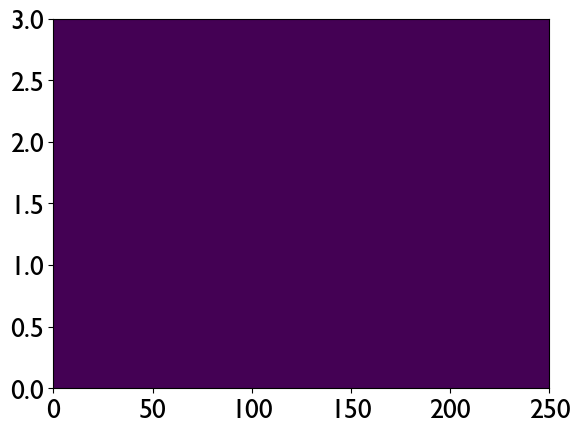

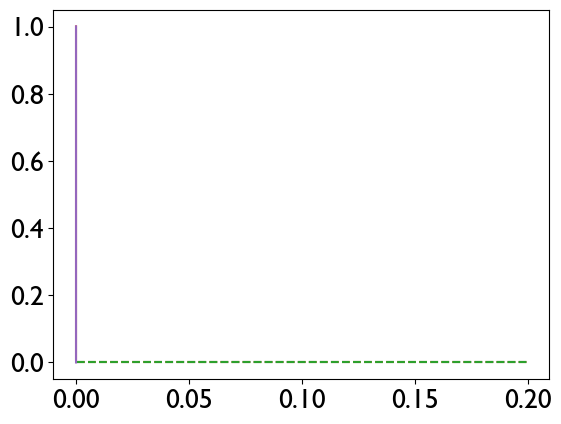

Q_func (generic function with 1 method)

In [55]:
Te_rect = zeros(Nr,Nz)
Ti_rect = zeros(Nr,Nz)
Te_rects = zeros(Nr,Nz)
Ti_rects = zeros(Nr,Nz)
for r in 1:Nr
    Te_rect[r,:] = itpTe(xs) .+ 1e-14
    Ti_rect[r,:] = itpTi(xs) .+ 1e-14
end
for r in 1:Nr
    Te_rects[r,:] = itpTes(xs) .+ 1e-14
    Ti_rects[r,:] = itpTis(xs) .+ 1e-14
end
Er_rect = a*Te_rect.^4
Te = reshape(Te_rect,Nz*Nr)
Ti = reshape(Ti_rect,Nz*Nr)
Er = reshape(Er_rect,Nz*Nr)
#space
Er_rects = a*Te_rects.^4
Tes = reshape(Te_rects,Nz*Nr)
Tis = reshape(Ti_rects,Nz*Nr)
Ers = reshape(Er_rects,Nz*Nr)
pcolor(reshape(Te_rect,Nr,Nz))
#plots of initial condition
figure()
plot(xs,reshape(Te,Nr,Nz)[1,:],"--")
plot(xs,reshape(Te,Nr,Nz)[2,:],"--")
plot(xs,reshape(Ti,Nr,Nz)[1,:],"--")
plot(init_cond[:,1],init_cond[:,2])
plot(init_cond[:,1],init_cond[:,3])
#define constants 
gamma0=0.5
rho=3.0
kappa0=100
cve_const = 0.3
cvi_const = 0.15
m=3/2
n=3
T0=1
sigma_func(t,T,Nr,Nz,Lr,Lz) = rho*kappa0*abs.(reshape(T,Nr,Nz)).^(-n)
D_func(t,T,Nr,Nz,Lr,Lz,Er,sigma) = 1.0./(rho*sigma)
Cve_func(t,T,Nr,Nz,Lr,Lz) = reshape(cve_const.+T*0, Nr,Nz)
EOSe(t,T,Nr,Nz,Lr,Lz) = cve_const*T
invEOSe(t,E,Nr,Nz,Lr,Lz) = (E/cve_const)
Cvi_func(t,T,Nr,Nz,Lr,Lz) = reshape(cvi_const.+T*0, Nr,Nz)
EOSi(t,T,Nr,Nz,Lr,Lz) = cvi_const*T
invEOSi(t,E,Nr,Nz,Lr,Lz) = (E/cvi_const)
gamma_func(t,Te,Ti,Nr,Nz,Lr,Lz) = (Te).^(-m)*gamma0/(t+tinit+1e-10)/2  #time dependent coupling coefficient 
function gamma_func_space(t,Te,Ti,Nr,Nz,Lr,Lz)   #space dependent coupling coefficient
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = range(0.5*dr, stop=Lr-0.5*dr, length=Nr)
    zcenter = range(0.5*dz, stop=Lz-0.5*dz, length=Nz)
    R,Z = meshgrid(rcenter,zcenter)
    Z = reshape(Z,Nr*Nz)
    #set A here
    alpha= a*c*4/(3*(n+4)*kappa0*cve_const*(T0^n)*rho)
    #alpha = a*c/3*4/(n+4)*1/(kappa0*cve_const)
    A = sqrt(1/(2*alpha))
    #set gamma0 here
    g0 = 0.5
    return g0*(Te).^(-m)./(2.0*A*A*Z.^2)
end

function Q_func(t,T,Nr,Nz,Lr,Lz)
    Q = zeros(Nr,Nz)
end

In [56]:
# time dependent gamma0 numerical solution 
dt = 0.0001
times, Er_t,Te_t,Ti_t = time_dep_3T(tfinal,dt,Te,Ti,Er,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);

times2, Er_t,Te_t,Ti_t = time_dep_3T(tfinal2,dt,Te,Ti,Er,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);
times3, Er_t,Te_t,Ti_t = time_dep_3T(tfinal3,dt,Te,Ti,Er,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);

1001
Step 1000, t = 0.099999999999999
10001
Step 10001, t = 0.999999999999999
20001
Step 20001, t = 1.999999999999999


In [57]:
#space dependent gamma0 numerical solution  
times_space, Er_ts,Te_ts,Ti_ts = time_dep_3T(tfinal,dt,Tes,Tis,Ers,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func_space,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);

times2_space, Er_ts,Te_ts,Ti_ts = time_dep_3T(tfinal2,dt,Te,Ti,Er,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func_space,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);
times3_space, Er_ts,Te_ts,Ti_ts = time_dep_3T(tfinal3,dt,Te,Ti,Er,D_func, sigma_func, Q_func,Q_func,Q_func,
    Cve_func,EOSe,invEOSe,
                      Cvi_func,EOSi,invEOSi,gamma_func_space,
                      Nr, Nz, Lr, Lz, lower_z=a, upper_z="vacuum", upper_r="refl",LOUD=-1);

1001
Step 1000, t = 0.099999999999999
10001
Step 10001, t = 0.999999999999999
20001
Step 20001, t = 1.999999999999999


### Time dependent $\gamma_0$ plots 

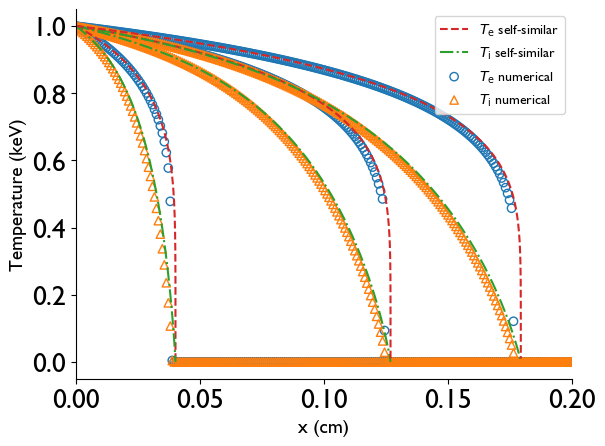

Any[]

In [58]:
using Plots
import PyPlot.legend
cmap = plt.get_cmap("tab10")

rc("font", family="Gill Sans")
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 20

ax = plt.gca()
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

hr = Lr/Nr
hz = Lz/Nz

zmid = range(hz*0.5, stop=Lz-hz*0.5,length=Nz)
T_plot = reshape(Te_t[:,size(times)[1]],Nr,Nz)
T_plot2= reshape(Te_t[:,size(times2)[1]],Nr,Nz)
T_plot3= reshape(Te_t[:,size(times3)[1]],Nr,Nz)

Ti_plot = reshape(Ti_t[:,size(times)[1]],Nr,Nz)
Ti_plot2 = reshape(Ti_t[:,size(times2)[1]],Nr,Nz)
Ti_plot3 = reshape(Ti_t[:,size(times3)[1]],Nr,Nz)

plt.scatter(zmid,T_plot[1,:,1],facecolors=:none,edgecolors=:C0,label=L"$T_\mathrm{e}$ numerical")
plt.scatter(zmid,T_plot2[1,:,1],facecolors=:none,edgecolors=:C0)
plt.scatter(zmid,T_plot3[1,:,1],facecolors=:none,edgecolors=:C0)

plt.scatter(zmid,Ti_plot[2,:,1],marker="^",facecolors=:none,edgecolors=:C1, label=L"$T_\mathrm{i}$ numerical")
plt.scatter(zmid,Ti_plot2[2,:,1],marker="^",facecolors=:none,edgecolors=:C1)
plt.scatter(zmid,Ti_plot3[2,:,1],marker="^",facecolors=:none,edgecolors=:C1)

plot(final_cond[:,1],final_cond[:,2],"--",label=L"$T_\mathrm{e}$ self-similar",c=:C3)
plot(final_cond[:,1],final_cond[:,3],"-.",label=L"$T_\mathrm{i}$ self-similar",c=:C2)


plot(final_cond2[:,1],final_cond2[:,3],"-.",c=:C2)
plot(final_cond2[:,1],final_cond2[:,2],"--",c=:C3)

plot(final_cond3[:,1],final_cond3[:,3],"-.",c=:C2)
plot(final_cond3[:,1],final_cond3[:,2],"--",c=:C3)

xlim(0,.2)
ax[:legend](loc="best", fontsize=10)
plt.xlabel("x (cm)",fontsize=14)

plt.ylabel("Temperature (keV)",fontsize=14)

plt.savefig("numerical_test_m0time",bbox_inches=:tight)



plot()


In [59]:
final_cond

9828×3 Array{Float64,2}:
 4.17385e-16  1.00041    1.00041
 1.90108e-6   1.00041    1.0004
 6.07493e-6   1.00039    1.00038
 1.02488e-5   1.00037    1.00036
 1.44226e-5   1.00036    1.00033
 1.85965e-5   1.00034    1.00031
 2.27703e-5   1.00032    1.00028
 2.69442e-5   1.00031    1.00026
 3.11181e-5   1.00029    1.00024
 3.52919e-5   1.00027    1.00021
 3.94658e-5   1.00026    1.00019
 4.36396e-5   1.00024    1.00016
 4.78135e-5   1.00022    1.00014
 ⋮                       
 0.0401029    0.0116702  7.28498e-11
 0.0401029    0.0114678  6.47502e-11
 0.0401029    0.0112453  5.65757e-11
 0.0401029    0.0109977  4.83156e-11
 0.0401029    0.0107172  3.99554e-11
 0.0401029    0.0105483  3.54091e-11
 0.0401029    0.010364   3.08247e-11
 0.0401029    0.0101615  2.61986e-11
 0.0401029    0.0101104  2.509e-11
 0.0401029    0.010058   2.39786e-11
 0.0401029    0.0100526  2.38672e-11
 0.0401029    0.0100472  2.37556e-11

### Space dependent $\gamma_0$ plots

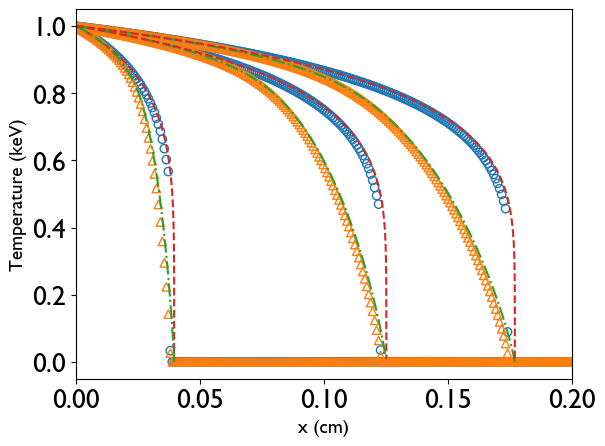

Any[]

In [60]:
zmid = range(hz*0.5, stop=Lz-hz*0.5,length=Nz)
T_plot = reshape(Te_ts[:,size(times_space)[1]],Nr,Nz)
T_plot2= reshape(Te_ts[:,size(times2_space)[1]],Nr,Nz)
T_plot3= reshape(Te_ts[:,size(times3_space)[1]],Nr,Nz)

Ti_plot = reshape(Ti_ts[:,size(times_space)[1]],Nr,Nz)
Ti_plot2 = reshape(Ti_ts[:,size(times2_space)[1]],Nr,Nz)
Ti_plot3 = reshape(Ti_ts[:,size(times3_space)[1]],Nr,Nz)

plt.scatter(zmid,T_plot[1,:,1],facecolors=:none,edgecolors=:C0,label=L"$T_\mathrm{e}$ numerical")
plt.scatter(zmid,T_plot2[1,:,1],facecolors=:none,edgecolors=:C0)
plt.scatter(zmid,T_plot3[1,:,1],facecolors=:none,edgecolors=:C0)

plt.scatter(zmid,Ti_plot[2,:,1],marker="^",facecolors=:none,edgecolors=:C1, label=L"$T_\mathrm{i}$ numerical")
plt.scatter(zmid,Ti_plot2[2,:,1],marker="^",facecolors=:none,edgecolors=:C1)
plt.scatter(zmid,Ti_plot3[2,:,1],marker="^",facecolors=:none,edgecolors=:C1)

plot(final_conds[:,1],final_conds[:,2],"--",label=L"$T_\mathrm{e}$ self-similar",c=:C3)
plot(final_conds[:,1],final_conds[:,3],"-.",label=L"$T_\mathrm{i}$ self-similar",c=:C2)

plot(final_cond2s[:,1],final_cond2s[:,3],"-.",c=:C2)
plot(final_cond2s[:,1],final_cond2s[:,2],"--",c=:C3)

plot(final_cond3s[:,1],final_cond3s[:,3],"-.",c=:C2)
plot(final_cond3s[:,1],final_cond3s[:,2],"--",c=:C3)

xlim(0,.2)
ax[:legend](loc="best", fontsize=10)
plt.xlabel("x (cm)",fontsize=14)

plt.ylabel("Temperature (keV)",fontsize=14)

plt.savefig("numerical_test_m32space",bbox_inches=:tight)

plot()